**Importing libraries**

In [2]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


**Defining constants**

In [3]:
omega_m = 0.272            #matter density paratmeter from Komatsu et al. (2011) 
omega_l = 1 - omega_m      #vacuum density paratmeter assuming flat universe
H_o = 70.4                 #Hubble constant in km s^−1 Mpc^−1 from Komatsu et al. (2011) 
h = 0.704
f = omega_m**0.545         #linear velocity growth rate from Tanimura et al. (2020)


**Defining Functions**

In [4]:
def H(z):                           #hubble parameter (in km s^-1 Mpc^-1) using Eq. 4.33 in Peter's book
    return np.sqrt( H_o**2 * ( (1+z)**3 * omega_m + omega_l ) ) 


**Reading galaxies dataset**

In [5]:
%%time
z = 0.42
# data_address = '../input/magneticumsnap027z042-massfiltered/'
data_address = 'Data/'
df_gal = pd.read_csv(data_address + 'massive_galaxies.csv')      #massive_galaxies.csv contains galaxies with mass greater than 1.8 ×10^{11} h^{−1} M_sun as done by Tanimura et al. (2020)
print(df_gal.describe())


            x[kpc/h]       y[kpc/h]       z[kpc/h]     m[Msol/h]
count   93097.000000   93097.000000   93097.000000  9.309700e+04
mean   325576.133087  322500.028738  320613.762863  3.993206e+11
std    184863.273960  182799.587421  183249.915097  3.995129e+11
min         1.864417      10.164207       0.260974  1.800010e+11
25%    163866.950000  166201.380000  162514.560000  2.161480e+11
50%    332449.620000  329260.160000  319925.780000  2.784900e+11
75%    483949.000000  475466.120000  478698.410000  4.192930e+11
max    639996.190000  639980.940000  639993.120000  1.077460e+13
CPU times: user 108 ms, sys: 4.37 ms, total: 112 ms
Wall time: 136 ms


**Reading clusters dataset**

In [6]:
%%time

df_clusters = pd.read_csv(data_address + 'massive_clusters.csv', 
                          usecols = ['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'm500c[Msol/h]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'    ])  #massive_clusters.csv contains clusters with M_500c greater than 10^13.5 h^{-1} M_sun as done by Tanimura et al. (2020)

#removing cluster at edges of the survey volume as done by Tanimura et al. 2020
df_clusters = df_clusters[(df_clusters['x[kpc/h]'] > 120000) & (df_clusters['x[kpc/h]'] < 530000) 
                          & (df_clusters['y[kpc/h]'] > 120000) & (df_clusters['y[kpc/h]'] < 530000) 
                          & (df_clusters['z[kpc/h]'] > 120000) & (df_clusters['z[kpc/h]'] < 530000)]
        
print(df_clusters.head())

    x[kpc/h]   y[kpc/h]   z[kpc/h]  m500c[Msol/h]   vx[km/s]  vy[km/s]  \
1  457001.00  220719.88  279137.47   4.723990e+14 -164.10600  315.2340   
3  178209.08  431001.19  432031.66   7.220310e+14 -112.36100 -193.4300   
4  232882.92  440987.19  452662.31   6.558890e+14  117.80100   64.2292   
6  519774.97  318721.50  440078.53   4.632420e+14   32.58170  462.1960   
7  370100.12  241020.95  476203.62   4.841180e+14    4.74288  231.0510   

   vz[km/s]  
1 -225.1460  
3  220.0250  
4   92.0462  
6   71.2611  
7 -122.2660  
CPU times: user 22.9 ms, sys: 4.41 ms, total: 27.3 ms
Wall time: 30.9 ms


**Specifying prefactors for Eq. 1 of Tanimura et al. (2020)**

In [7]:
a = 1/(1+z)
H(z)
print(H(z))

pre_fac = (f * a * H(z) / (4 * np.pi))
pre_fac

86.417665668


2.3820143592892085

**Evaluating Eq. 1 of Tanimura el al. 2020**

In [8]:
%%time

pix_size = 5000                      #h^-1 kpc, size of pixel or cell
FWHM = 2000                          #h^-1 kpc, of Gaussian kernel, taken by Tanimura et al. 2020
FWHM_in_pix = 2000/pix_size          #in pixel units
sigma_in_pix = FWHM_in_pix/(2.35482) #in pixel units
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

#specifing position of the clusters
Rclus_x = np.zeros((48, 48, 48))
Rclus_x[:] = 120000
Rclus_y = np.zeros((48, 48, 48))
Rclus_y[:] = 120000
Rclus_z = np.zeros((48, 48, 48))
Rclus_z[:] = 120000

#generating meshgrid containing coordinates of the centers of cells
x = np.arange(2500, 238000, 5000)
Rcell_x, Rcell_y, Rcell_z = np.meshgrid(x, x, x)

#evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

#calculating the differential in the Eq. 1
dy_cubed = pix_size**3

#evaluating the direction term in the numerator of Eq. 1
numer_x = Rcell_x - Rclus_x
numer_y = Rcell_y - Rclus_y
numer_z = Rcell_z - Rclus_z

#generating empty lists to store velocity estimates later on
vx_est_list = []
vy_est_list = []
vz_est_list = []

def density_field_calc(clus_x, clus_y, clus_z):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_gal[(df_gal['x[kpc/h]'] >= (clus_x - 120000)) & (df_gal['x[kpc/h]'] < (clus_x + 120000))
                            & (df_gal['y[kpc/h]'] >= (clus_y - 120000)) & (df_gal['y[kpc/h]'] < (clus_y + 120000)) 
                             & (df_gal['z[kpc/h]'] >= (clus_z - 120000)) & (df_gal['z[kpc/h]'] < (clus_z + 120000))]
    
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['x[kpc/h]'] -= (clus_x-120000)
    df_gal_cube['y[kpc/h]'] -= (clus_y-120000)
    df_gal_cube['z[kpc/h]'] -= (clus_z-120000)

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['x[kpc/h]'] = df_gal_cube['x[kpc/h]'] / 5000
    df_gal_cube['y[kpc/h]'] = df_gal_cube['y[kpc/h]'] / 5000
    df_gal_cube['z[kpc/h]'] = df_gal_cube['z[kpc/h]'] / 5000
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'].astype(int), df_gal_cube['y[kpc/h]'].astype(int), df_gal_cube['z[kpc/h]'].astype(int)))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((48, 48, 48))
    
    #counting number of galaxies in the cells
    for cell in df_gal_cube["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1
        
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/np.mean(gals_in_cell)) - 1
        
    #smoothing the overdensity of galaxies
    delta_gal_smooth = gaussian_filter(delta_gal, sigma = sigma_in_pix)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(h*1e3)) / denom #in units of Mpc    
    vx_est = pre_fac * np.sum(integrand_x)
    vx_est_list.append(vx_est)
    
#     print(df_clusters)
    
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(h*1e3)) / denom #in units of Mpc    
    vy_est = pre_fac * np.sum(integrand_y)
    vy_est_list.append(vy_est)
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(h*1e3)) / denom #in units of Mpc    
    vz_est = pre_fac * np.sum(integrand_z)
    vz_est_list.append(vz_est)


clus_param = [(clus_x, clus_y, clus_z) for clus_x, clus_y, clus_z
              in zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'])]


# counter = 0

for clus_x, clus_y, clus_z in zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]']):
    density_field_calc(clus_x, clus_y, clus_z)
    
#     counter += 1
#     if counter == 5:
#         break

CPU times: user 22.4 s, sys: 3.44 s, total: 25.8 s
Wall time: 25.8 s


**Line of sight velocity**

54.7356103172


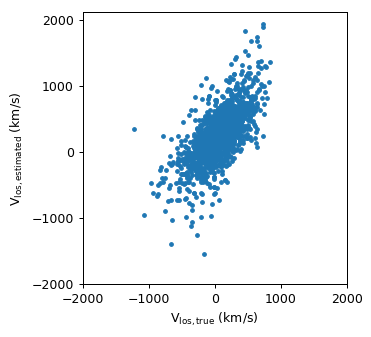

In [51]:
#line of sight assumed to along main diagonal(from '0,0,0' -> '650,650,650') of the simulation cube

theta = np.arccos(1/np.sqrt(1+1+1))
print(theta*(180/np.pi))

vx_est_array = np.array(vx_est_list)
vy_est_array = np.array(vy_est_list)
vz_est_array = np.array(vz_est_list)

v_los_est = (vx_est_array * np.cos(theta)) + (vy_est_array * np.cos(theta)) + (vz_est_array * np.cos(theta))
v_los_true = (df_clusters['vx[km/s]'] * np.cos(theta)) + (df_clusters['vy[km/s]'] * np.cos(theta)) + (df_clusters['vz[km/s]'] * np.cos(theta))

plt.figure(dpi = dpi)
plt.scatter(v_los_true, v_los_est, s = 8)
plt.xlabel('V$_\mathrm{los, true}$ (km/s)')
plt.ylabel('V$_\mathrm{los, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

286.039868564 -200.997082468


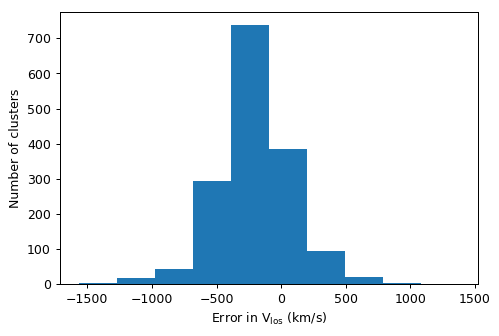

In [26]:
error_v_los = v_los_true - v_los_est

plt.figure(dpi = dpi)
plt.hist(error_v_los)
plt.xlabel('Error in V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('Number of clusters')

print(np.std(error_v_los), np.mean(error_v_los))

**V$_y$ estimate & error**

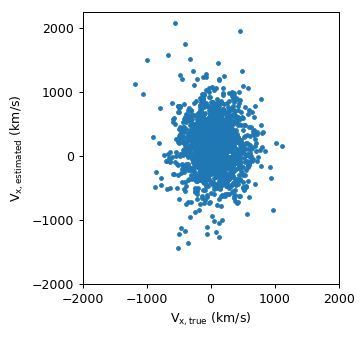

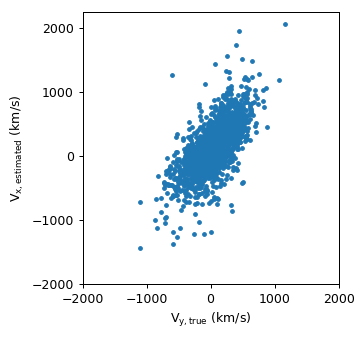

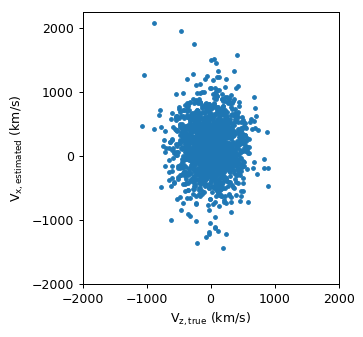

In [62]:
dpi = 90
plt.figure(dpi = dpi)
plt.scatter(df_clusters['vx[km/s]'], vx_est_list, s = 8)
plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vy[km/s]'], vx_est_list, s = 8)
plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vz[km/s]'], vx_est_list, s = 8)
plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)');
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

294.592783988 -105.787819564


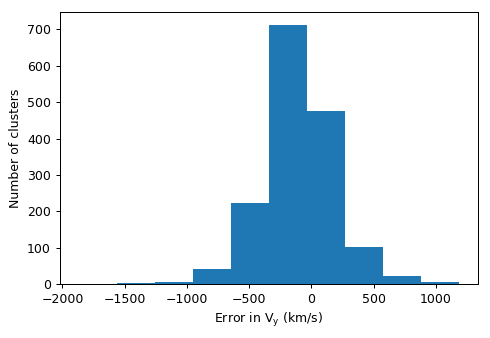

In [11]:
error_y = df_clusters['vy[km/s]'] - vx_est_list

plt.figure(dpi = dpi)
plt.hist(error_y)
plt.xlabel('Error in V$_{\mathrm{y}}$ (km/s)')
plt.ylabel('Number of clusters')

print(np.std(error_y), np.mean(error_y))

**V$_x$ estimate & error**

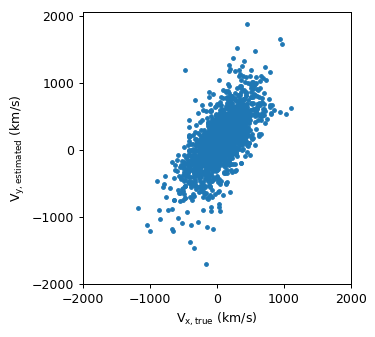

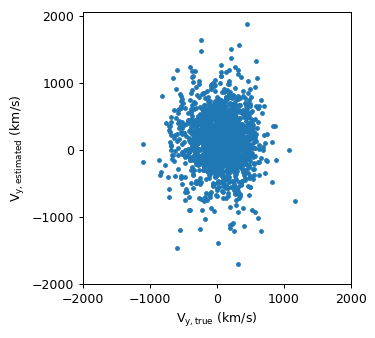

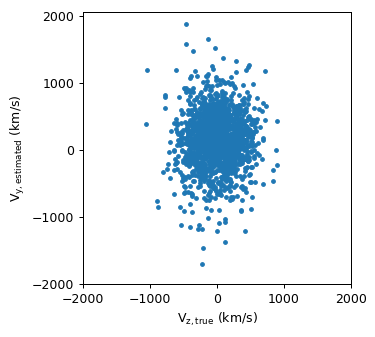

In [63]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters['vx[km/s]'], vy_est_list, s = 8)
plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vy[km/s]'], vy_est_list, s = 8)
plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vz[km/s]'], vy_est_list, s = 8)
plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)');
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

297.754610597 -94.9141333966


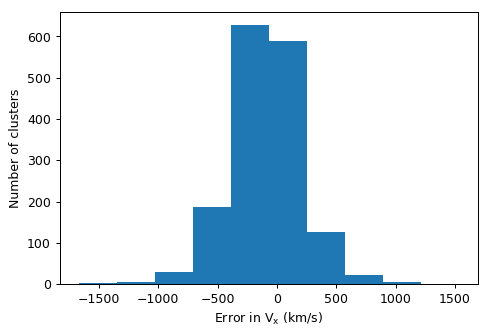

In [13]:
error_x = df_clusters['vx[km/s]'] - vy_est_list

plt.figure(dpi = dpi)
plt.hist(error_x)
plt.xlabel('Error in V$_{\mathrm{x}}$ (km/s)')
plt.ylabel('Number of clusters')

print(np.std(error_x), np.mean(error_x))

**V$_z$ estimate & error**

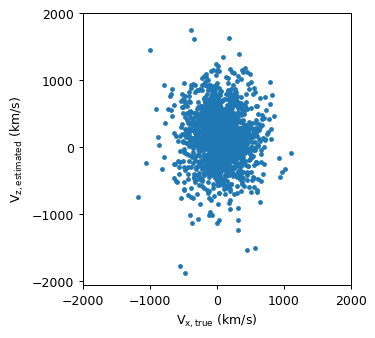

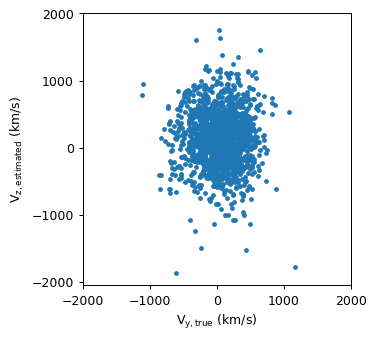

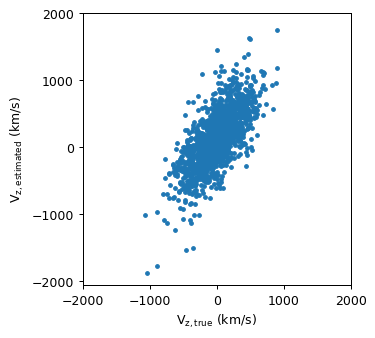

In [64]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters['vx[km/s]'], vz_est_list, s = 8)
plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vy[km/s]'], vz_est_list, s = 8)
plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)')
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

plt.figure(dpi = dpi)
plt.scatter(df_clusters['vz[km/s]'], vz_est_list, s = 8)
plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)');
plt.gca().set_xticks(range(-2000, 2001, 1000))
plt.gca().set_yticks(range(-2000, 2001, 1000))
plt.gca().set_aspect('equal', adjustable='box')

288.353670099 -147.435206047


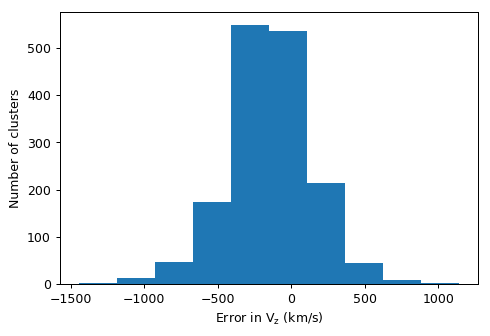

In [15]:
error_z = df_clusters['vz[km/s]'] - vz_est_list

plt.figure(dpi = dpi)
plt.hist(error_z)
plt.xlabel('Error in V$_{\mathrm{z}}$ (km/s)')
plt.ylabel('Number of clusters')

print(np.std(error_z), np.mean(error_z))

In [16]:
print(x)
print(Rcell_x[:, :, 0])
print(Rcell_x[:, 0, :])
print(Rcell_x[0, :, :])

[  2500   7500  12500  17500  22500  27500  32500  37500  42500  47500
  52500  57500  62500  67500  72500  77500  82500  87500  92500  97500
 102500 107500 112500 117500 122500 127500 132500 137500 142500 147500
 152500 157500 162500 167500 172500 177500 182500 187500 192500 197500
 202500 207500 212500 217500 222500 227500 232500 237500]
[[  2500   7500  12500 ..., 227500 232500 237500]
 [  2500   7500  12500 ..., 227500 232500 237500]
 [  2500   7500  12500 ..., 227500 232500 237500]
 ..., 
 [  2500   7500  12500 ..., 227500 232500 237500]
 [  2500   7500  12500 ..., 227500 232500 237500]
 [  2500   7500  12500 ..., 227500 232500 237500]]
[[2500 2500 2500 ..., 2500 2500 2500]
 [2500 2500 2500 ..., 2500 2500 2500]
 [2500 2500 2500 ..., 2500 2500 2500]
 ..., 
 [2500 2500 2500 ..., 2500 2500 2500]
 [2500 2500 2500 ..., 2500 2500 2500]
 [2500 2500 2500 ..., 2500 2500 2500]]
[[  2500   2500   2500 ...,   2500   2500   2500]
 [  7500   7500   7500 ...,   7500   7500   7500]
 [ 12500  1250

In [17]:
denom[0, :, :]

array([[  8.42937708e+15,   8.08076027e+15,   7.75192510e+15, ...,
          7.75192510e+15,   8.08076027e+15,   8.42937708e+15],
       [  8.08076027e+15,   7.73708652e+15,   7.41304695e+15, ...,
          7.41304695e+15,   7.73708652e+15,   8.08076027e+15],
       [  7.75192510e+15,   7.41304695e+15,   7.09366185e+15, ...,
          7.09366185e+15,   7.41304695e+15,   7.75192510e+15],
       ..., 
       [  7.75192510e+15,   7.41304695e+15,   7.09366185e+15, ...,
          7.09366185e+15,   7.41304695e+15,   7.75192510e+15],
       [  8.08076027e+15,   7.73708652e+15,   7.41304695e+15, ...,
          7.41304695e+15,   7.73708652e+15,   8.08076027e+15],
       [  8.42937708e+15,   8.08076027e+15,   7.75192510e+15, ...,
          7.75192510e+15,   8.08076027e+15,   8.42937708e+15]])